In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%qtconsole

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from loren_frank_data_processing.position import (
    make_track_graph, get_interpolated_position_dataframe, get_trial_time)
from loren_frank_data_processing.track_segment_classification import plot_track
from src.parameters import ANIMALS

epoch_key = ('bon', 3, 2)

track_graph, _ = make_track_graph(epoch_key, ANIMALS)


time = get_trial_time(epoch_key, ANIMALS)
time = (pd.Series(np.ones_like(time, dtype=np.float), index=time)
        .resample('1ms').mean()
        .index)

def _time_function(*args, **kwargs):
    return time

position_info = (
    get_interpolated_position_dataframe(epoch_key, ANIMALS, _time_function)
    .dropna(subset=['linear_distance', 'linear_speed']))

/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


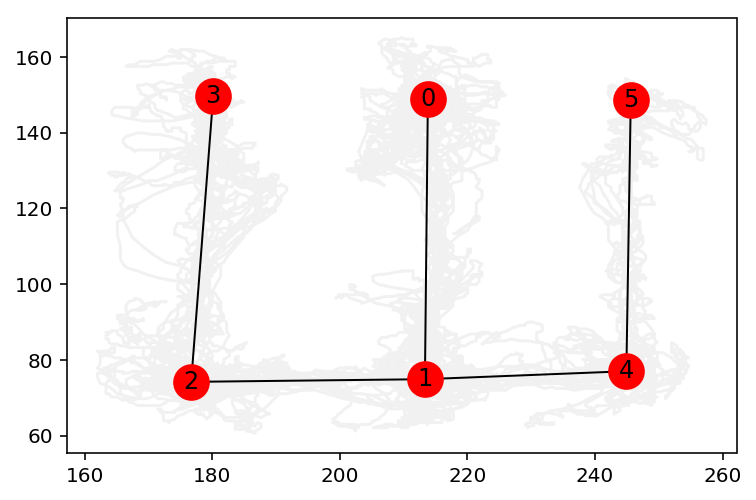

In [4]:
plt.plot(position_info.x_position.values, position_info.y_position.values,
         color='lightgrey', alpha=0.3, zorder=0)
plot_track(track_graph)

In [5]:
import networkx as nx

node_positions = nx.get_node_attributes(track_graph, 'pos')
node_positions

1, 1/2
2, 1/3
3, 1/4
4, 6

(4, 6)

In [6]:
def get_inbetween_nodes(node1, node2, node_positions, position_ind, n_nodes):
    node_spacing = (node_positions[node2][position_ind] -
                    node_positions[node1][position_ind]) / (n_nodes + 1)
    inbetween_positions = node_positions[node1][position_ind] + np.arange(1, n_nodes + 1) * node_spacing
    inbetween_positions = inbetween_positions[:, np.newaxis]
    other_position_ind = int(position_ind == 0)
    
    if other_position_ind == 0:
        x = np.ones_like(inbetween_positions) * node_positions[node1][other_position_ind]
        return np.concatenate((x, inbetween_positions), axis=1)
    else:
        y = np.ones_like(inbetween_positions) * node_positions[node1][other_position_ind]
        return np.concatenate((inbetween_positions, y), axis=1)

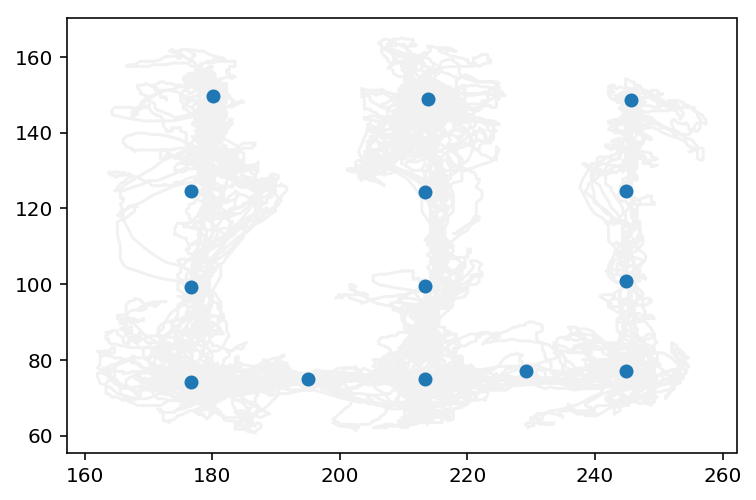

In [7]:
place_field_centers = np.concatenate((
    np.asarray(list(node_positions.values())),
    get_inbetween_nodes(2, 3, node_positions, position_ind=1, n_nodes=2),
    get_inbetween_nodes(1, 0, node_positions, position_ind=1, n_nodes=2),
    get_inbetween_nodes(4, 5, node_positions, position_ind=1, n_nodes=2),
    get_inbetween_nodes(1, 2, node_positions, position_ind=0, n_nodes=1),
    get_inbetween_nodes(4, 1, node_positions, position_ind=0, n_nodes=1),
), axis=0)


plt.plot(position_info.x_position.values, position_info.y_position.values,
         color='lightgrey', alpha=0.3, zorder=0)
plt.scatter(place_field_centers[:, 0], place_field_centers[:, 1])

In [321]:
from replay_trajectory_classification.simulate import simulate_neuron_with_place_field
from src.parameters import SAMPLING_FREQUENCY

position = position_info.loc[:, ['x_position', 'y_position']].values
is_training = position_info.speed > 4
spikes = np.stack(
    [simulate_neuron_with_place_field(center, position, max_rate=15, sigma=100,
                                      sampling_frequency=SAMPLING_FREQUENCY)
     for center in place_field_centers], axis=1)

In [435]:
from replay_trajectory_classification import SortedSpikesClassifier

classifier = SortedSpikesClassifier(
        movement_var=np.sqrt(15/SAMPLING_FREQUENCY), replay_speed=80,
        discrete_transition_diag=1 - 1E-3).fit(
    position, spikes, is_training=is_training)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


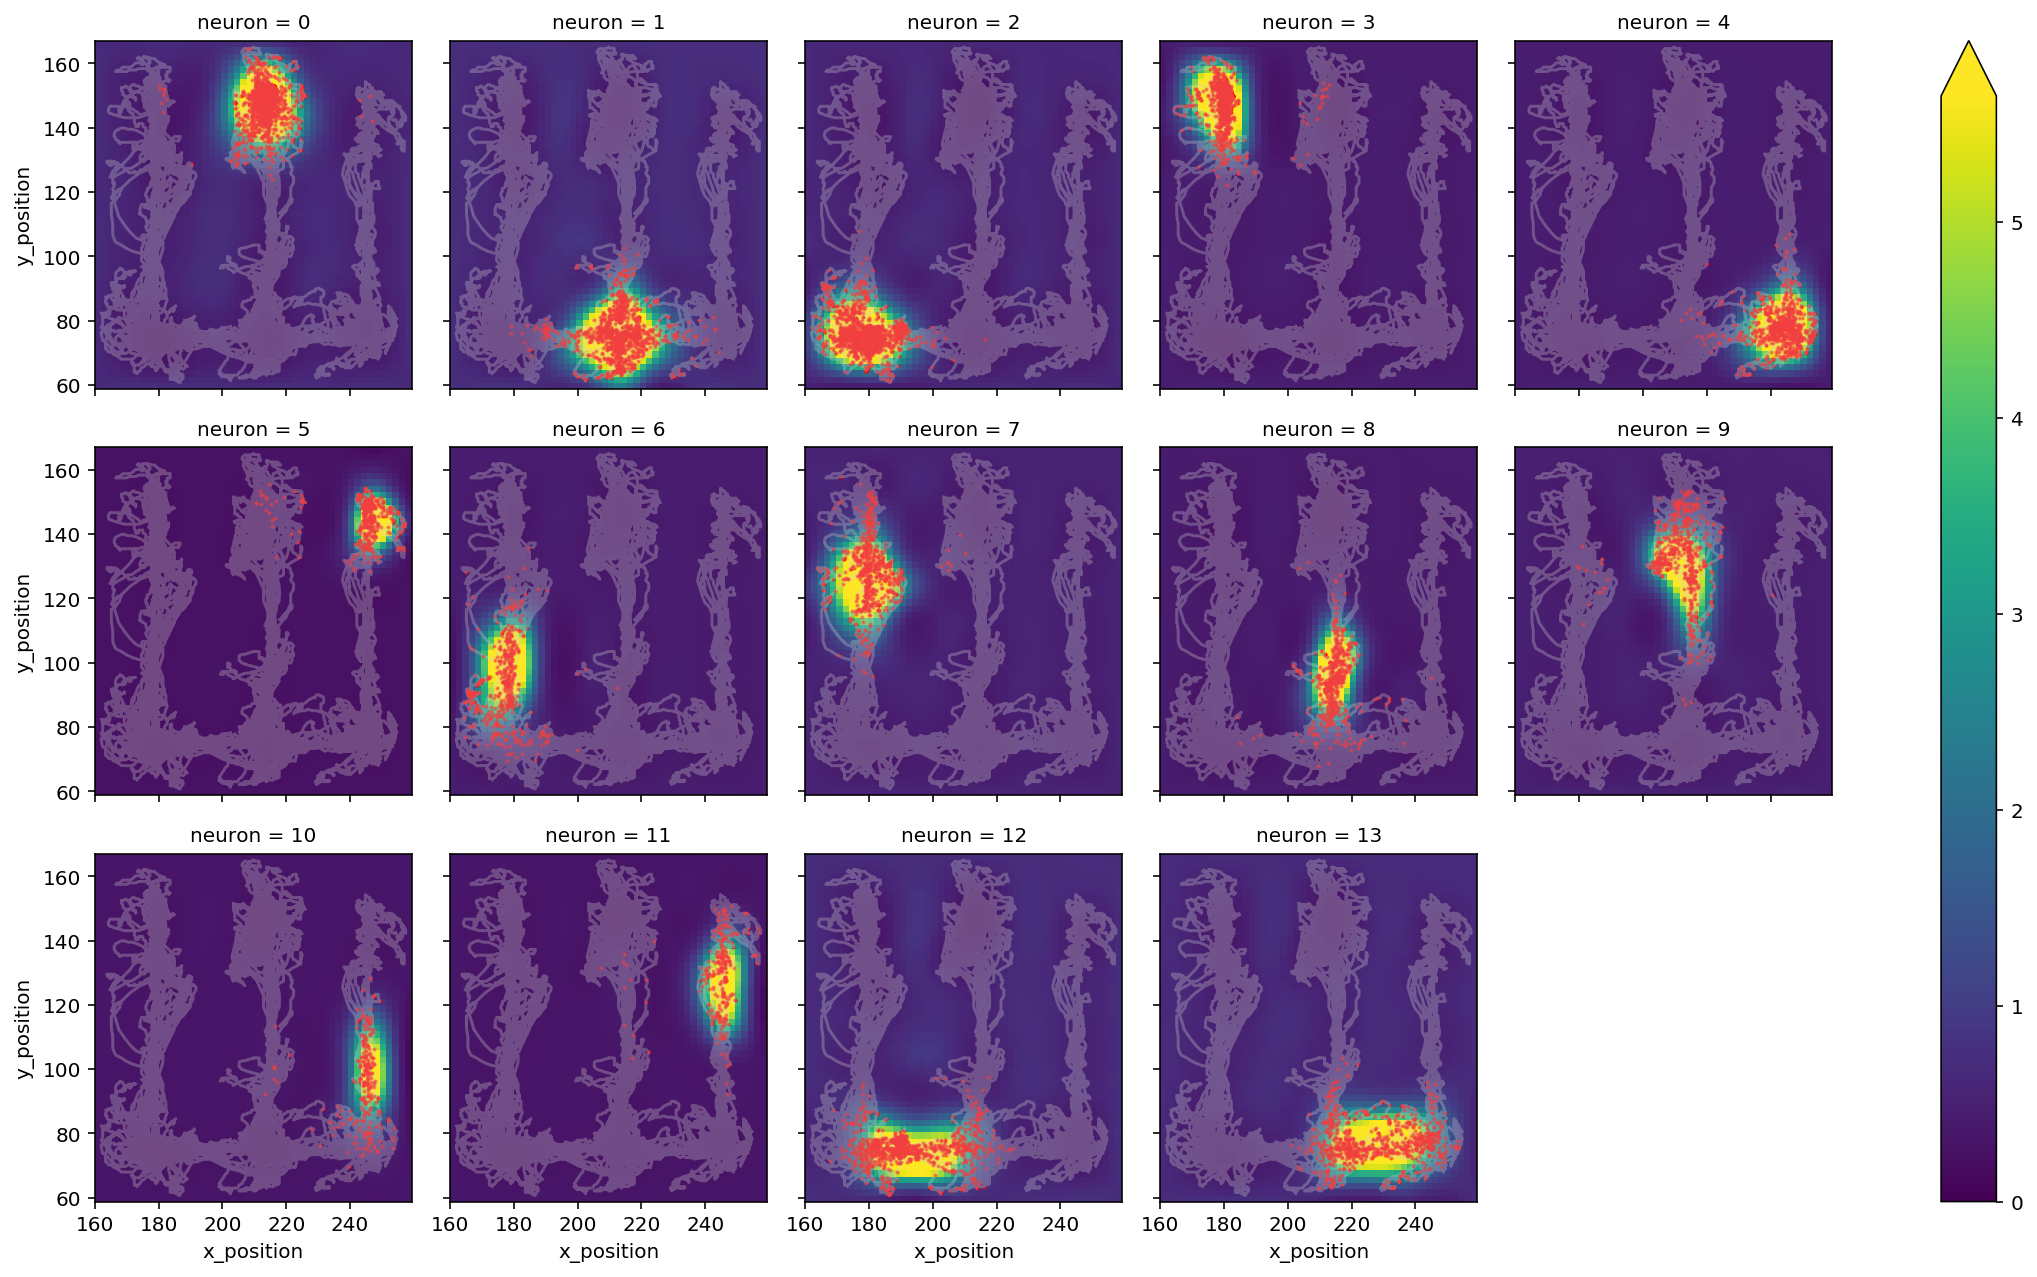

In [331]:
g = classifier.plot_place_fields(
    spikes, position, SAMPLING_FREQUENCY)

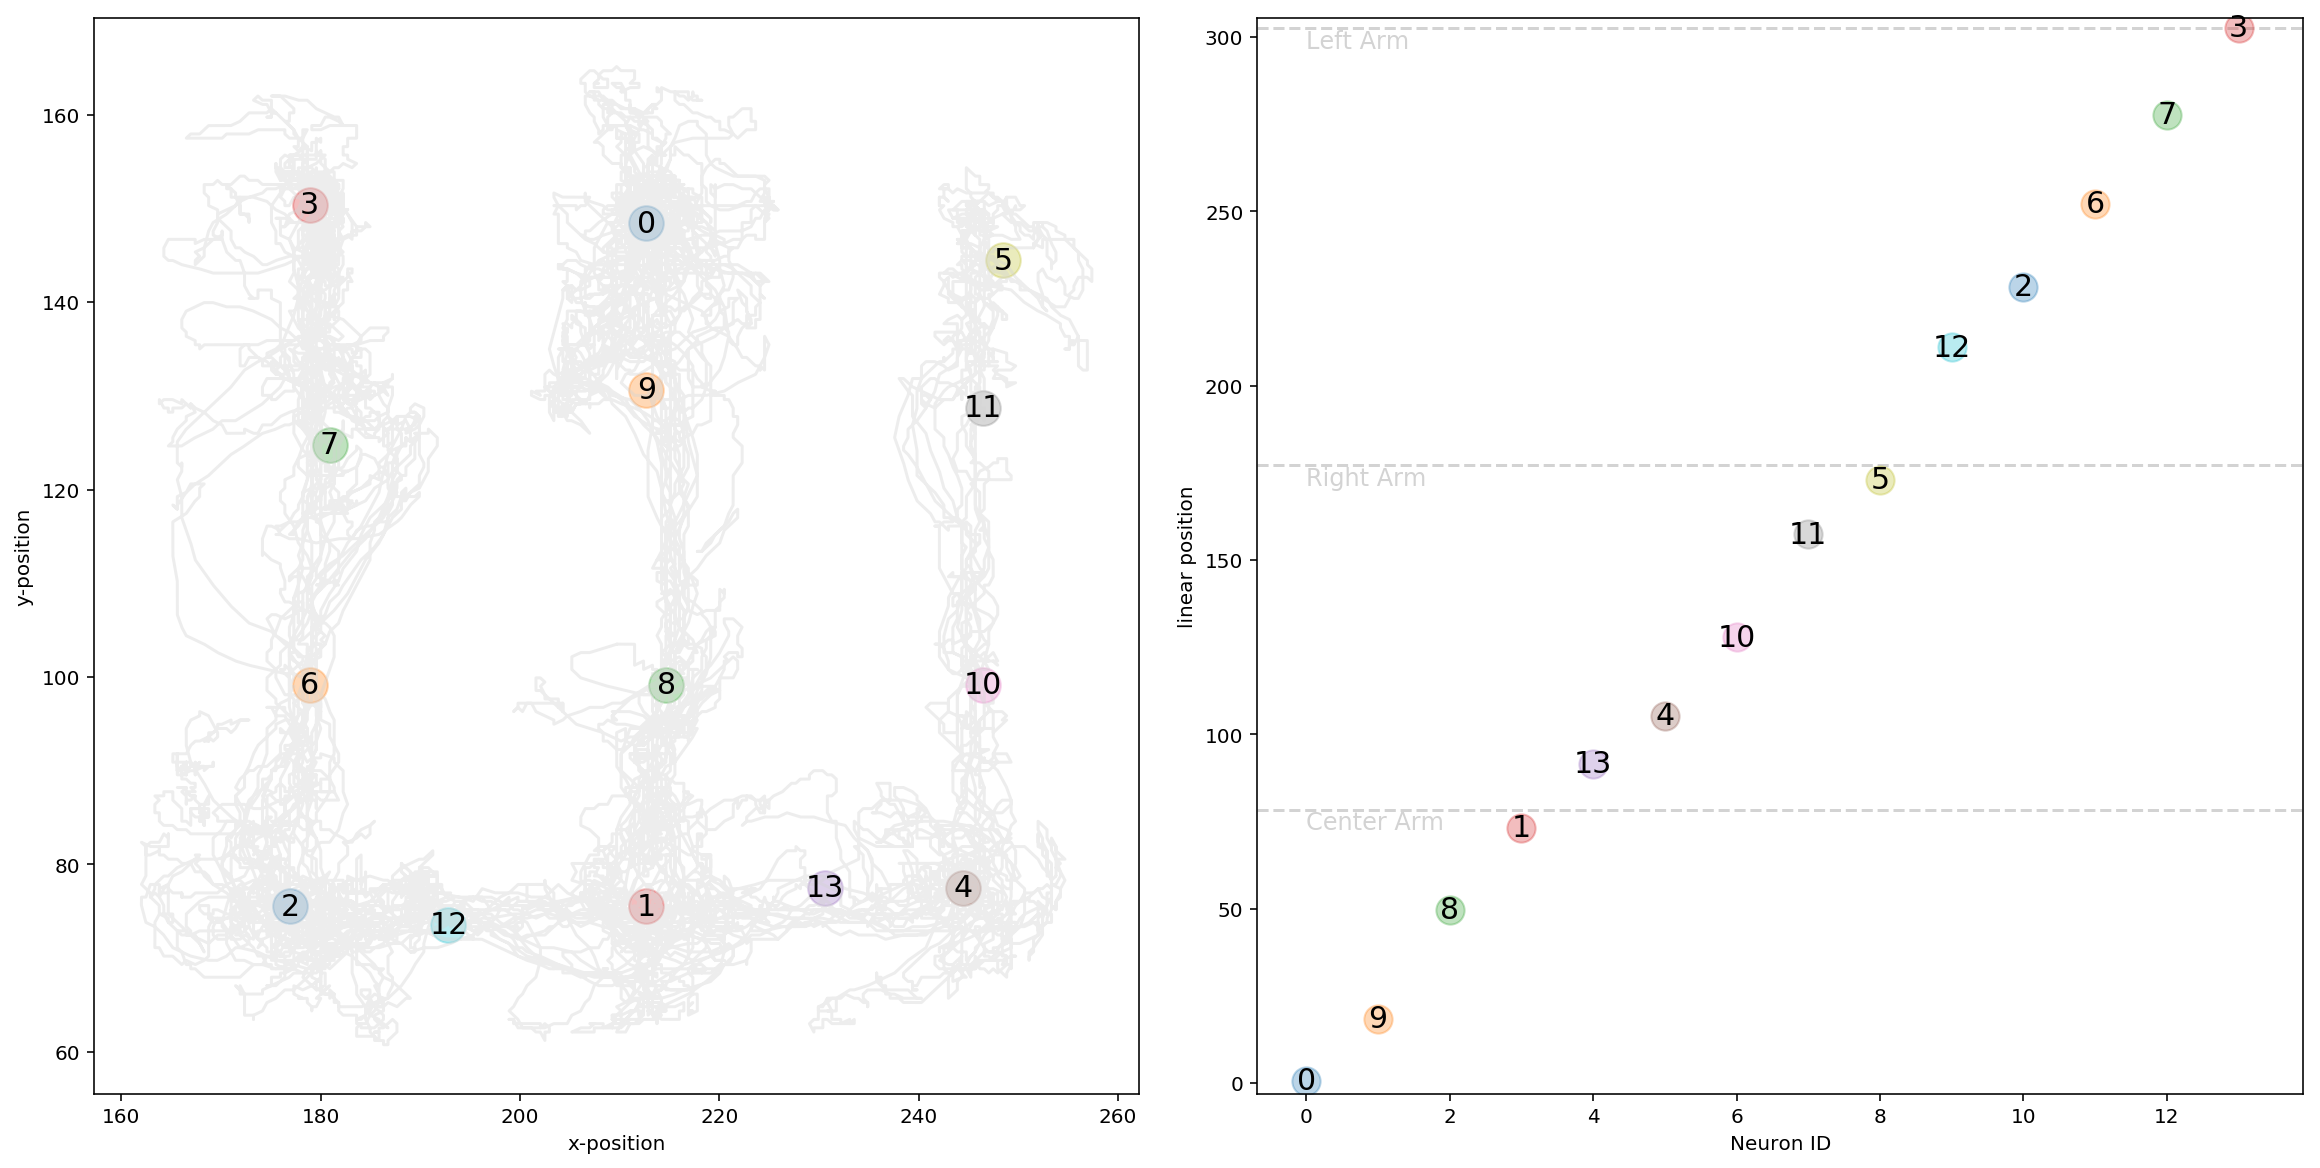

In [332]:
from src.analysis import get_linear_position_order, get_place_field_max
from src.visualization import plot_neuron_place_field_2D_1D_position

place_field_max = get_place_field_max(classifier)
linear_position_order, linear_place_field_max = get_linear_position_order(
    position_info, place_field_max)
plot_neuron_place_field_2D_1D_position(
    position_info, place_field_max, linear_place_field_max, 
    linear_position_order)

## Continuous

In [356]:
def get_euclidean_dist(x):
    return np.linalg.norm(x[:-1] - x[1:], axis=1)

def get_min_ind(position, place_field_max):
    return np.asarray(
        [np.linalg.norm(position - m, axis=1).argmin()
         for m in place_field_max])


neuron_ind = np.asarray([0, 9, 8, 1, 13, 4, 10, 11, 5])

# p = position_info.loc[position_info.labeled_segments == 19, ['x_position', 'y_position']]
# min_ind = get_min_ind(p.values, place_field_max[neuron_ind])
# spike_time_ind = min_ind // SPEEDUP
SPEEDUP = 70
AVG_SPEED = 15 / SAMPLING_FREQUENCY # cm / bin
dist = get_euclidean_dist(place_field_centers[neuron_ind])

spike_time_ind = np.cumsum(
    np.insert(np.floor(dist / AVG_SPEED // SPEEDUP), 0, 2)).astype(np.int)

n_neurons = spikes.shape[1]
n_time = int(spike_time_ind.max() + 1)
time = np.arange(n_time) / SAMPLING_FREQUENCY
test_spikes = np.zeros((n_time, n_neurons))
test_spikes[(spike_time_ind, neuron_ind)] = 1.0

result = classifier.predict(test_spikes, time)

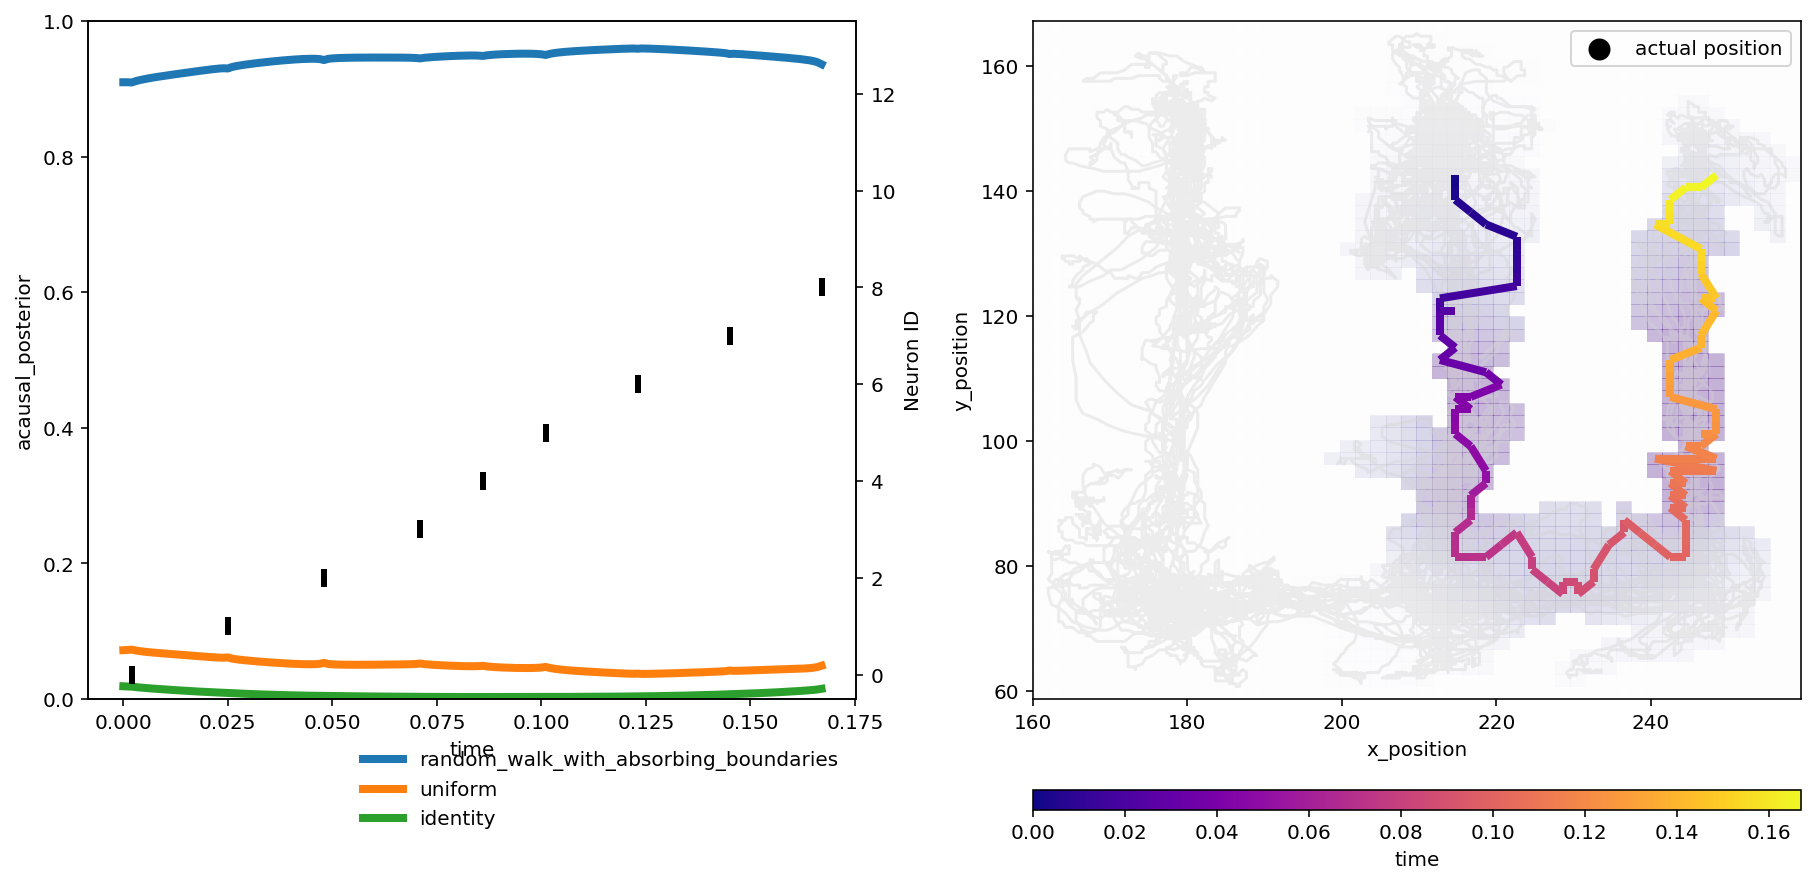

In [357]:
from src.visualization import plot_ripple_decode

ripple_position = np.zeros((n_time, 2))

plot_ripple_decode(result.acausal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

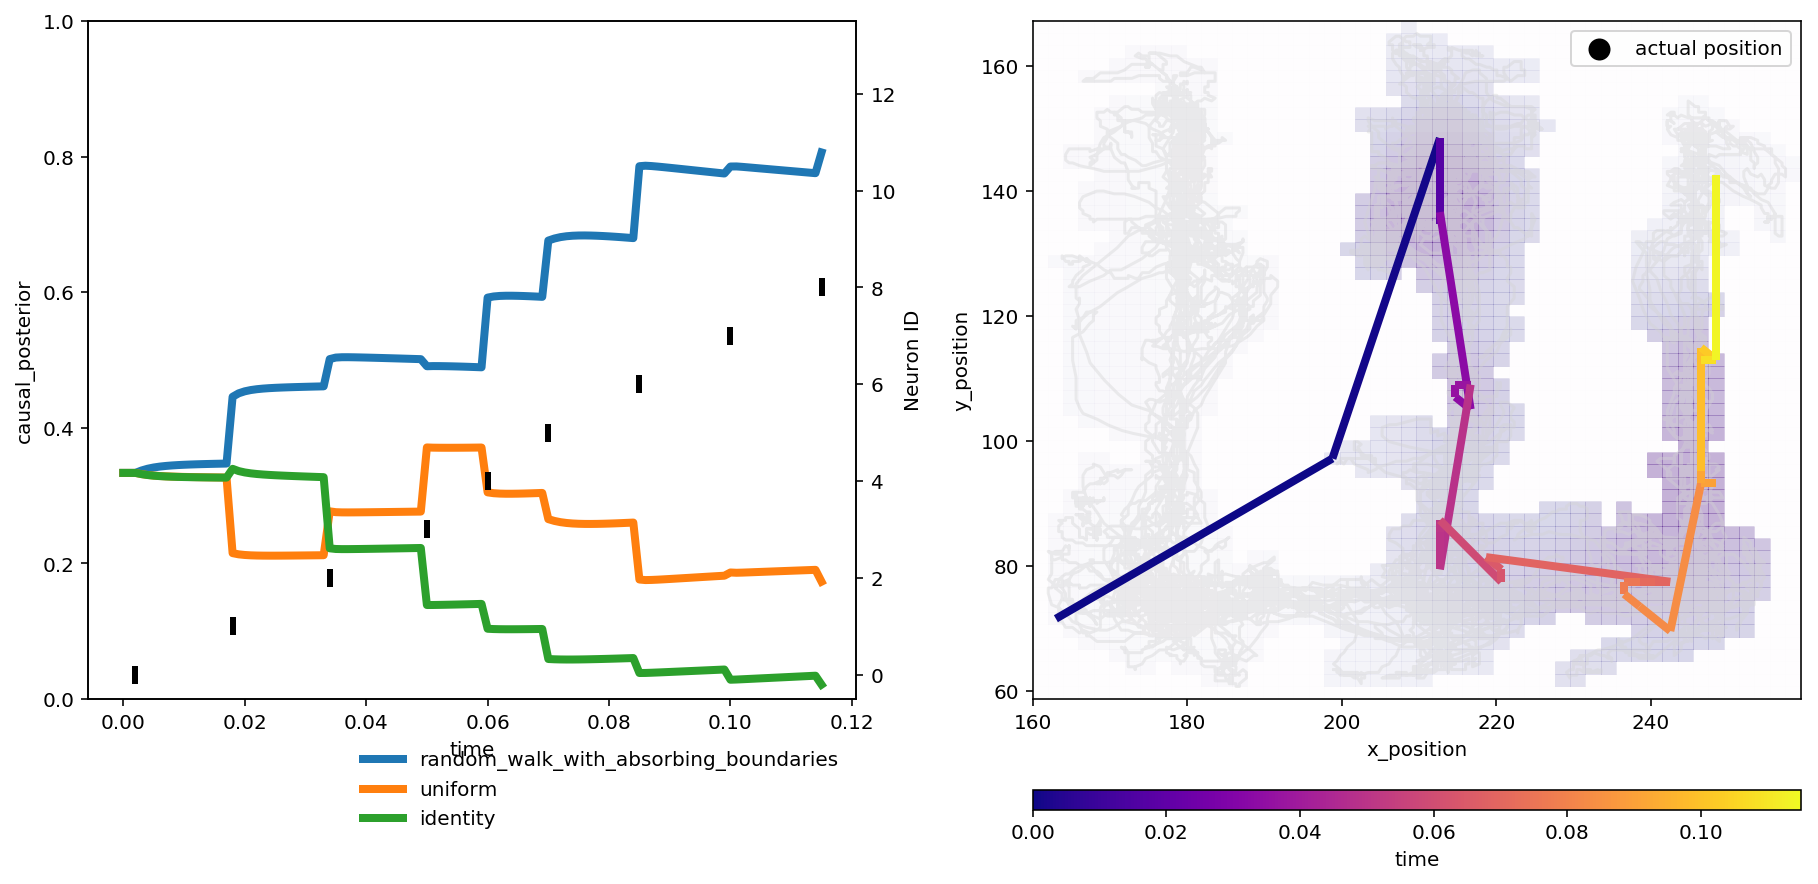

In [355]:
from src.visualization import plot_ripple_decode

ripple_position = np.zeros((n_time, 2))

plot_ripple_decode(result.causal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

In [337]:
from ipywidgets import interact

n_time = result.time.size

@interact(time_ind=(0, n_time-1))
def _plot_result(time_ind=0):
    g = (result.causal_posterior
         .isel(time=time_ind)
         .plot(x='x_position', y='y_position', col='state',
               size=5, vmin=0.0, vmax=result.causal_posterior.quantile(0.999)))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')

interactive(children=(IntSlider(value=0, description='time_ind', max=294), Output()), _dom_classes=('widget-in…

## Hover

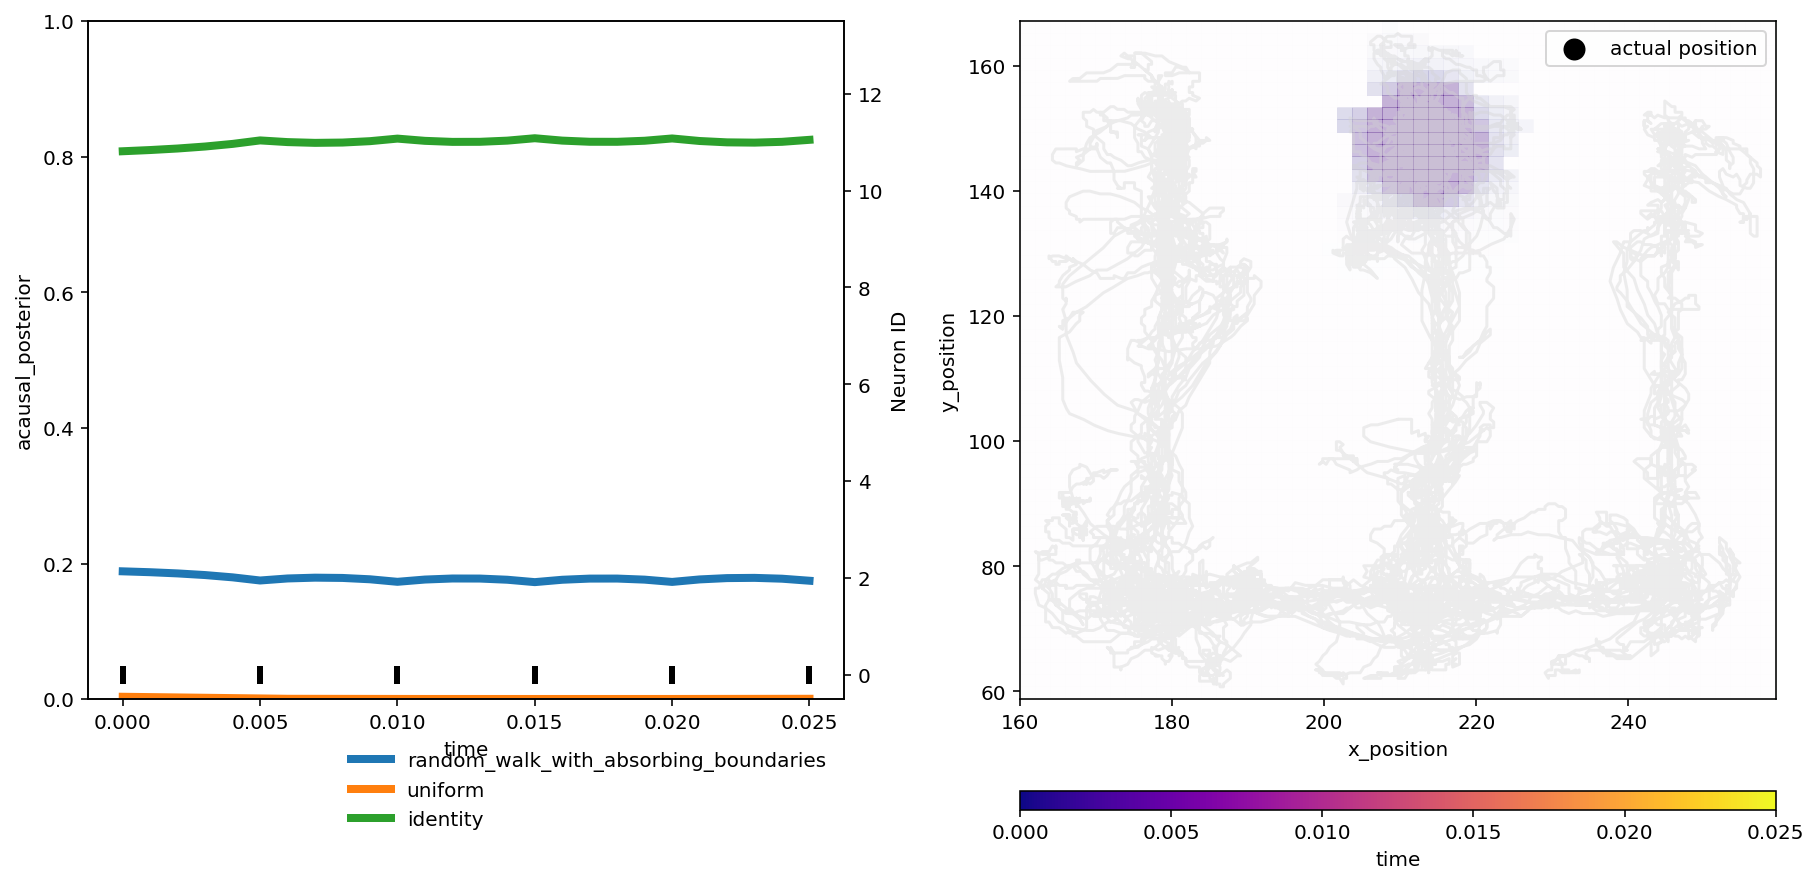

In [359]:
neuron_ind = np.zeros((6,), dtype=np.int)

spike_time_ind = np.arange(0, neuron_ind.size * 5, 5)

n_neurons = spikes.shape[1]
n_time = int(spike_time_ind.max() + 1)
time = np.arange(n_time) / SAMPLING_FREQUENCY
test_spikes = np.zeros((n_time, n_neurons))
test_spikes[(spike_time_ind, neuron_ind)] = 1.0

result = classifier.predict(test_spikes, time)

plot_ripple_decode(result.acausal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

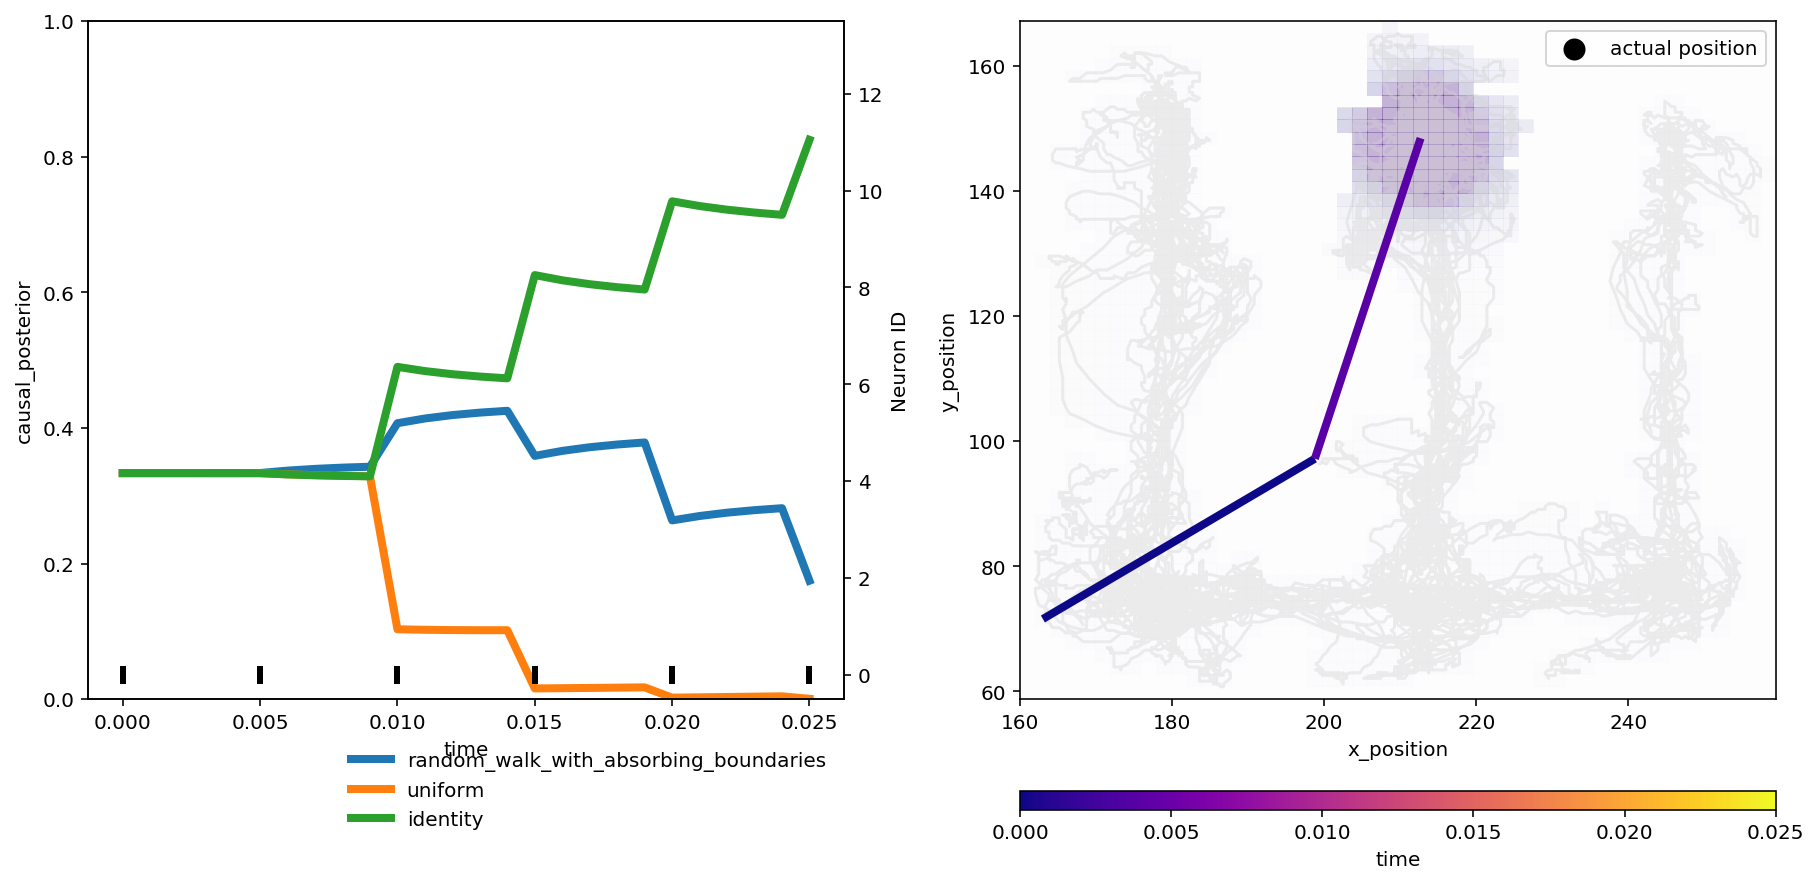

In [360]:
plot_ripple_decode(result.causal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

## Fragmented

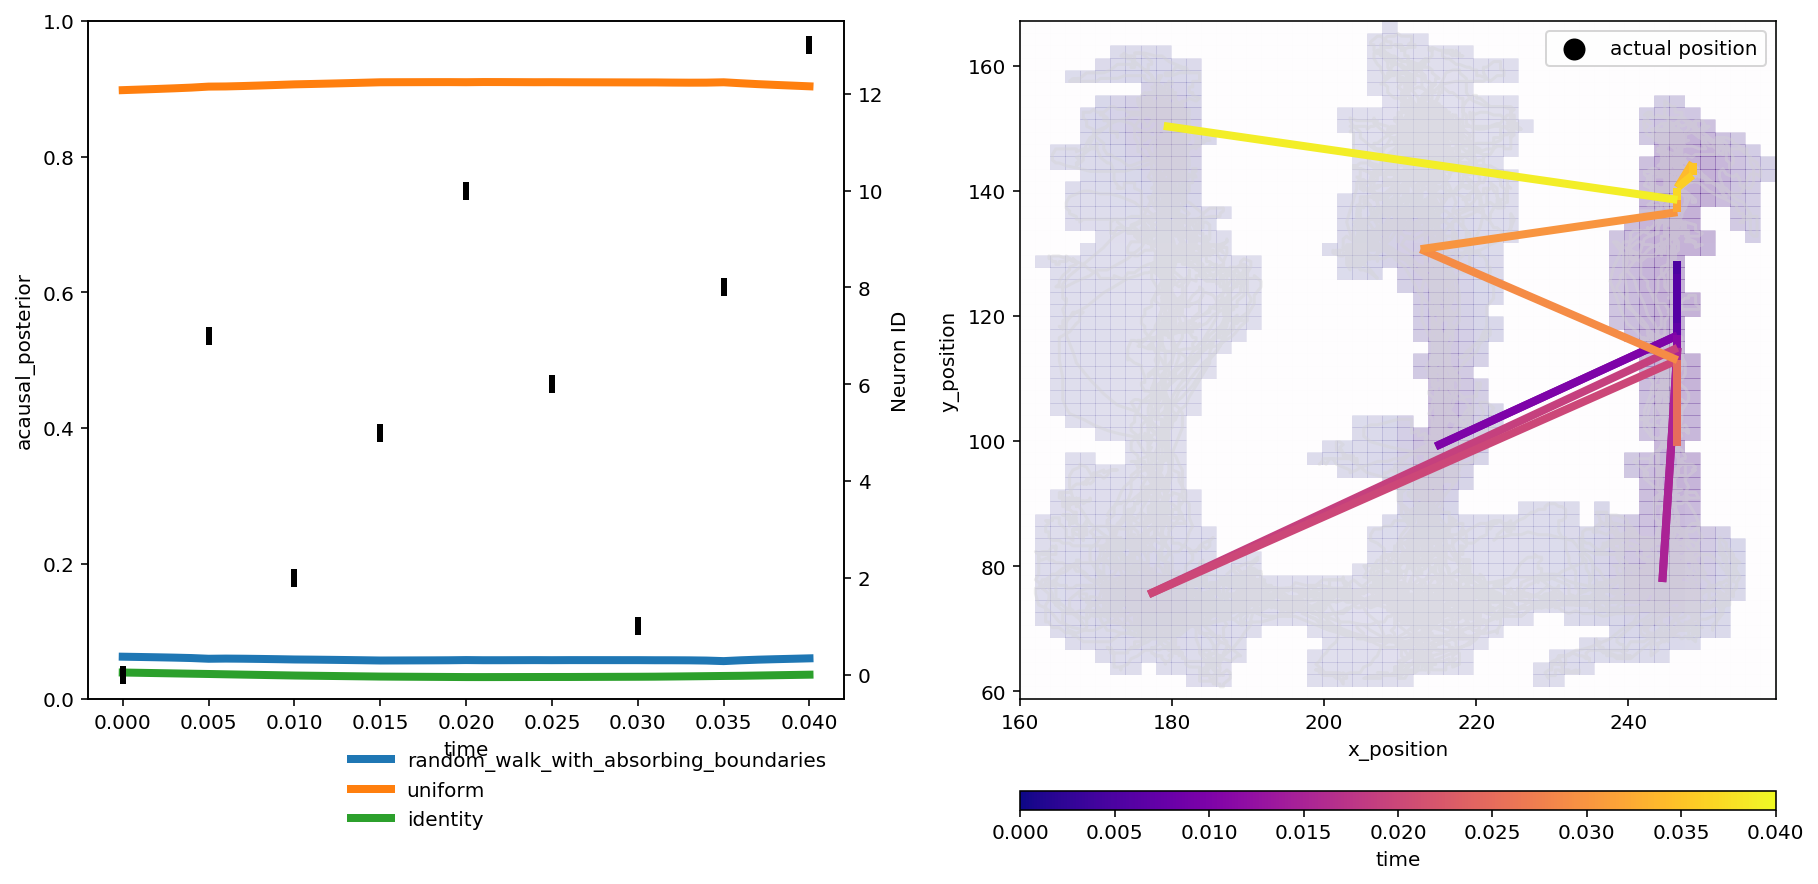

In [362]:
neuron_ind = np.asarray([0, 11, 8, 4, 2, 10, 9, 5, 3])
spike_time_ind = np.arange(0, neuron_ind.size * 5, 5)
n_neurons = spikes.shape[1]
n_time = int(spike_time_ind.max() + 1)
time = np.arange(n_time) / SAMPLING_FREQUENCY
test_spikes = np.zeros((n_time, n_neurons))
test_spikes[(spike_time_ind, neuron_ind)] = 1.0

result = classifier.predict(test_spikes, time)

plot_ripple_decode(result.acausal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

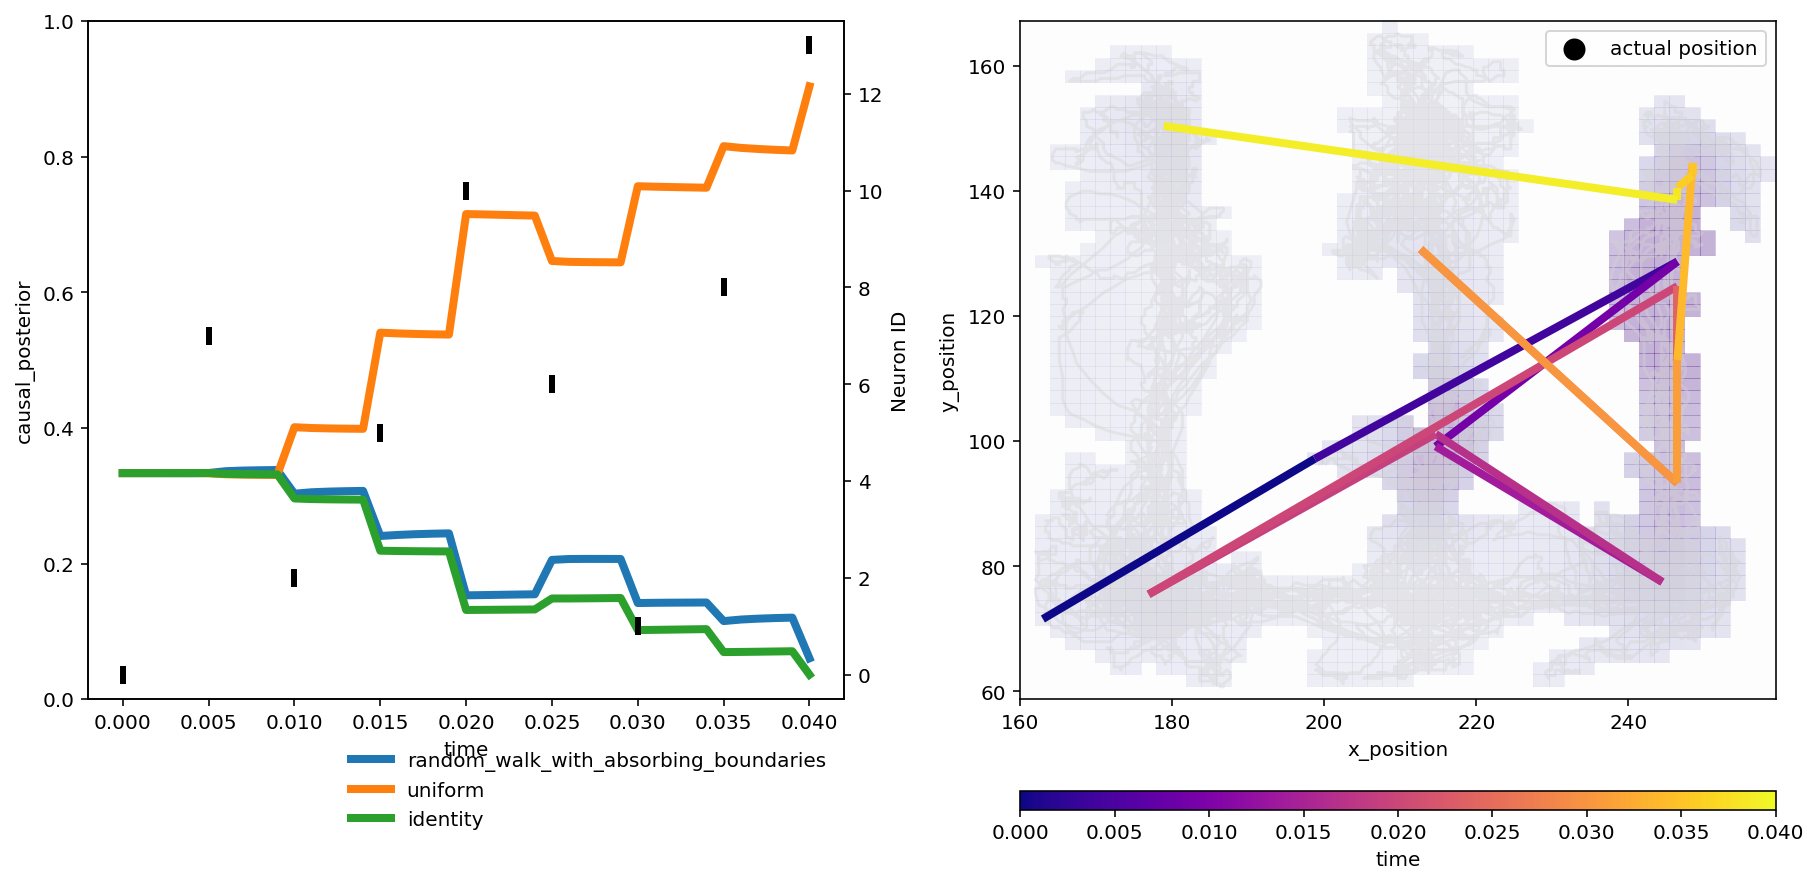

In [364]:
plot_ripple_decode(result.causal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

In [275]:
from ipywidgets import interact

n_time = result.time.size

@interact(time_ind=(0, n_time-1))
def _plot_result(time_ind=0):
    g = (result.causal_posterior
         .isel(time=time_ind)
         .plot(x='x_position', y='y_position', col='state',
               size=5, vmin=0.0, vmax=result.causal_posterior.quantile(0.999)
              ))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')

interactive(children=(IntSlider(value=0, description='time_ind', max=287), Output()), _dom_classes=('widget-in…

In [221]:
from ipywidgets import interact
import xarray as xr

nonzero_ind = np.nonzero(classifier.is_track_interior_.ravel(order='F'))[0]
n_nonzero_ind = len(nonzero_ind)


data = classifier.continuous_state_transition_
dims = ['state', 'position_t_1', 'position_t']
position_coord_t_1 = pd.MultiIndex.from_arrays(
            classifier.place_bin_centers_.T.tolist(), names=['x_position_t_1', 'y_position_t_1'])
position_coord_t = pd.MultiIndex.from_arrays(
            classifier.place_bin_centers_.T.tolist(), names=['x_position_t', 'y_position_t'])
coords = {
    'state': classifier.continuous_transition_types,
    'position_t_1': position_coord_t_1,
    'position_t': position_coord_t
}
st = xr.DataArray(data, dims=dims, coords=coords)
st

@interact(ind=(0, n_nonzero_ind))
def _plot_st(ind=154):
    vmax = float(st.isel(state=0).max())
    g = (st
     .isel(position_t_1=nonzero_ind[ind])
     .unstack('position_t')
     .plot(x='x_position_t', y='y_position_t', col='state', vmin=0.0, vmax=vmax, size=5))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')

interactive(children=(IntSlider(value=154, description='ind', max=1373), Output()), _dom_classes=('widget-inte…

In [130]:
n_time = result.time.size

@interact(time_ind=(0, n_time-1))
def _plot_result(time_ind=0):
    g = (result.causal_posterior
         .isel(time=time_ind)
         .plot(x='x_position', y='y_position', col='state', size=5, vmin=0.0, vmax=0.001))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')
        
    g = (result.likelihood
         .isel(time=time_ind)
         .plot(x='x_position', y='y_position', col='state', size=5))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')

interactive(children=(IntSlider(value=0, description='time_ind', max=95), Output()), _dom_classes=('widget-int…

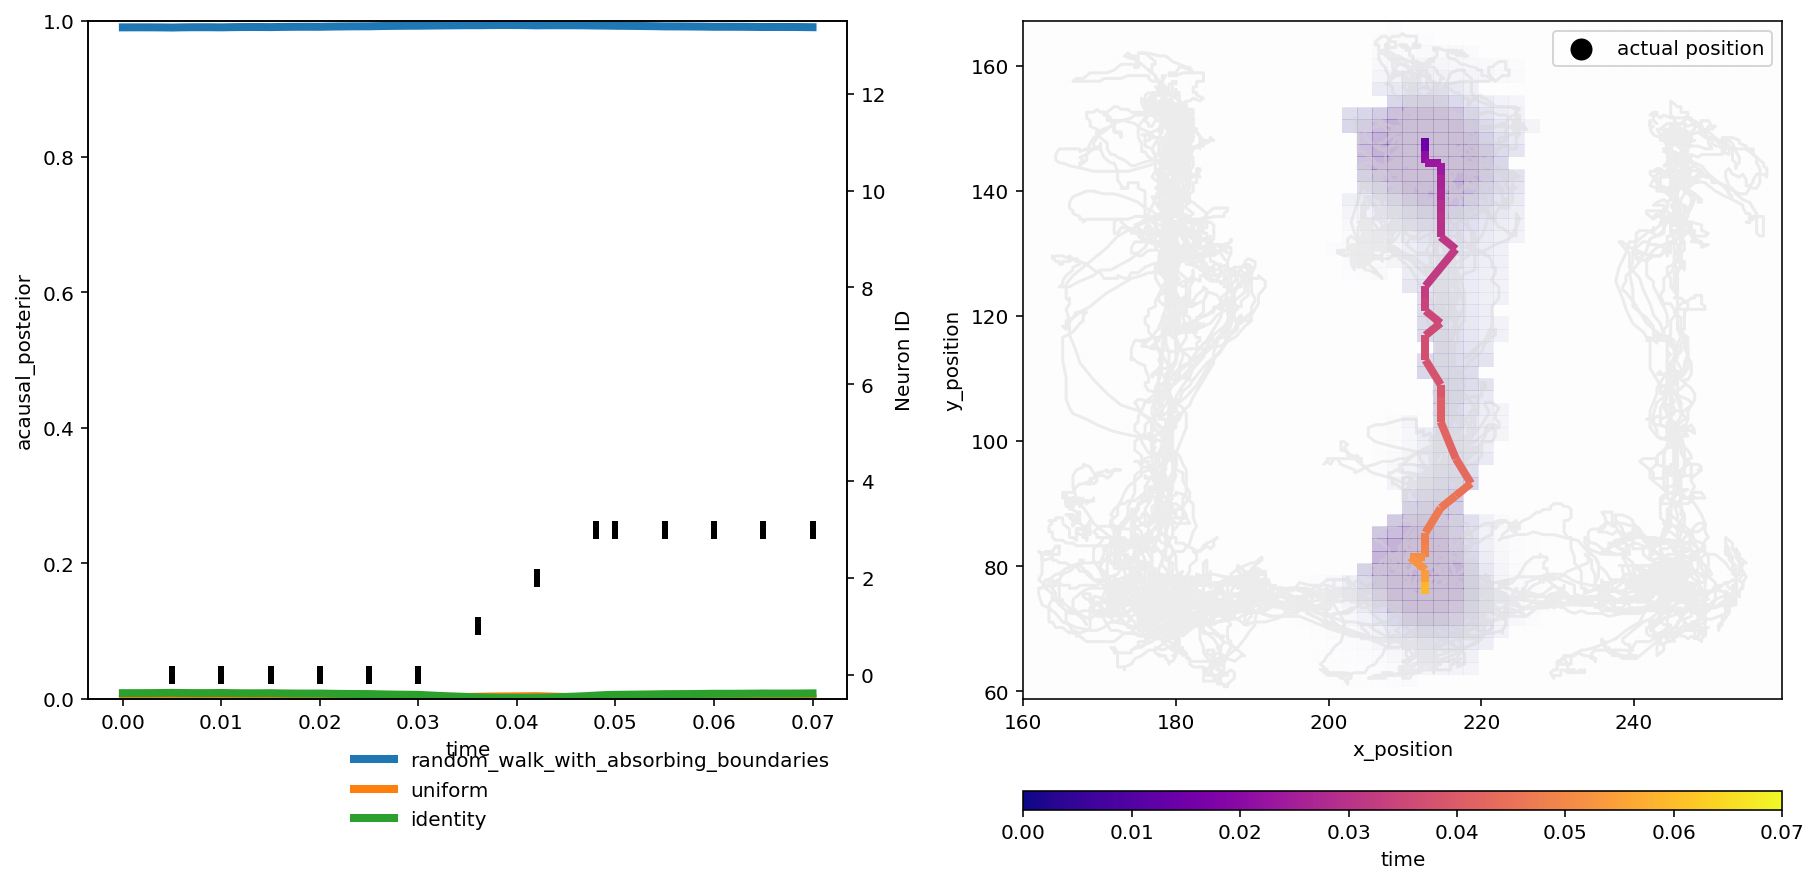

In [429]:
neuron_ind = np.asarray([0, 0, 0, 0, 0,
                         0, 9, 8, 1,
                         1, 1, 1, 1, 1])
spike_time_ind = np.asarray([5, 10, 15, 20, 25, 30,
                             36, 42, 48,
                             50, 55, 60, 65, 70])
n_neurons = place_field_centers.shape[0]
n_time = int(spike_time_ind.max() + 1)
time = np.arange(n_time) / SAMPLING_FREQUENCY
test_spikes = np.zeros((n_time, n_neurons))
test_spikes[(spike_time_ind, neuron_ind)] = 1.0

result = classifier.predict(test_spikes, time)

plot_ripple_decode(result.acausal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

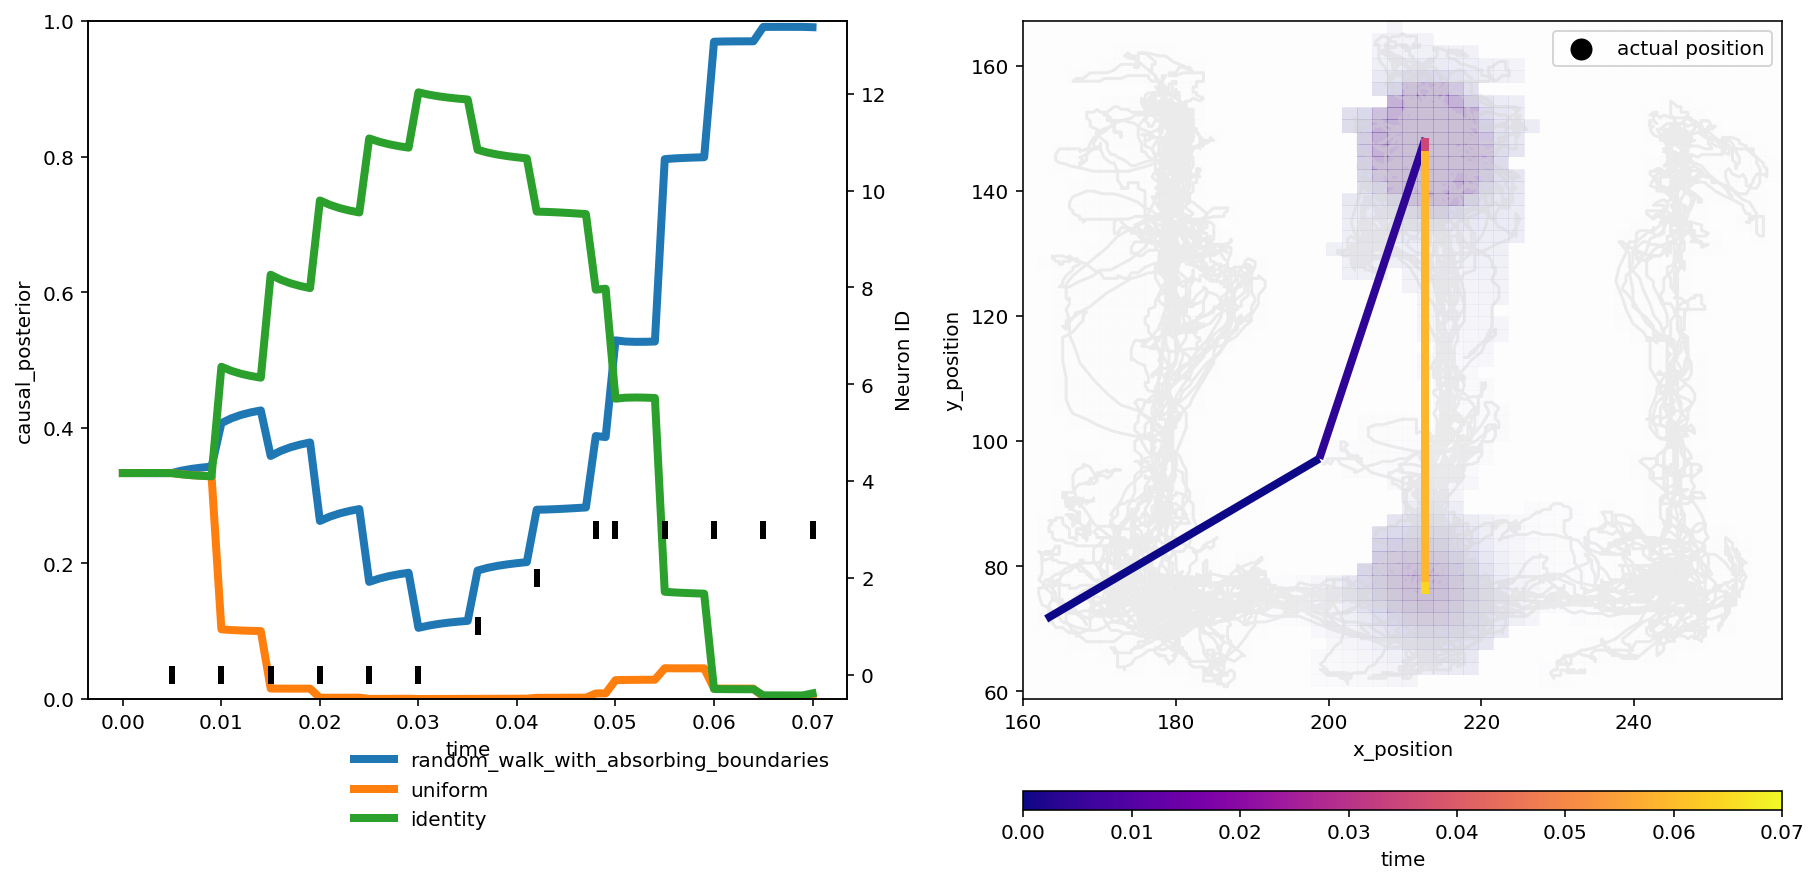

In [432]:
plot_ripple_decode(result.causal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

In [434]:
from ipywidgets import interact

n_time = result.time.size

@interact(time_ind=(0, n_time-1))
def _plot_result(time_ind=0):
    g = (result.causal_posterior
         .isel(time=time_ind)
         .plot(x='x_position', y='y_position', col='state',
               size=5, vmin=0.0, vmax=result.causal_posterior.quantile(0.99)))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')


interactive(children=(IntSlider(value=0, description='time_ind', max=70), Output()), _dom_classes=('widget-int…